# Using SURFsara IoT platform for Sensemakers - demo #1

This notebook shows how to:
- access files in the shared volume
- load raw data JSON files into a pandas DataFrame
- perform simple data manipulations
- inspect data
- produce plots
- store results in the project volume for later use

## Accessing files in the shared volume

The messages processed by the automated data pipeline are written into the shared volume. The individual messages are appended to files for a given project/device and a calendar date. The naming convention for the directories/files is `/data/app_id/dev_id-YYYY-MM-DD.json`. The shared volume is accessible from Jupyter notebooks in read-only mode under `/home/shared`.

The files in the shared volume can be listed in the following way:

In [1]:
!ls /home/shared/WON/SMA-A42924*

/home/shared/WON/SMA-A42924-2019-09-17.json
/home/shared/WON/SMA-A42924-2019-09-18.json
/home/shared/WON/SMA-A42924-2019-09-19.json
/home/shared/WON/SMA-A42924-2019-09-20.json
/home/shared/WON/SMA-A42924-2019-09-21.json
/home/shared/WON/SMA-A42924-2019-09-22.json
/home/shared/WON/SMA-A42924-2019-09-23.json
/home/shared/WON/SMA-A42924-2019-09-24.json
/home/shared/WON/SMA-A42924-2019-10-01.json
/home/shared/WON/SMA-A42924-2019-10-04.json
/home/shared/WON/SMA-A42924-2019-10-05.json
/home/shared/WON/SMA-A42924-2019-10-06.json
/home/shared/WON/SMA-A42924-2019-10-07.json
/home/shared/WON/SMA-A42924-2019-10-08.json
/home/shared/WON/SMA-A42924-2019-10-09.json


The files contain raw messages in the JSON format line-by-line.

In [2]:
!head /home/shared/WON/SMA-A42924-2019-10-09.json

{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 13}, "time": 1570579212418}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 13}, "time": 1570579243368}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 13}, "time": 1570579274070}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 13}, "time": 1570579304818}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 13}, "time": 1570579335819}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 12}, "time": 1570579366433}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 12}, "time": 1570579397294}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 72, "temp": 12}, "time": 1570579428098}
{"app_id": "WON", "dev_id": "SMA-A42924", "payload_fields": {"hum": 71, "temp": 12}, "time": 1570579458919}
{"app_id": "WON", "dev_id": 

## Load raw data JSON files into a pandas DataFrame

We choose to use [pandas](https://pandas.pydata.org/) DataFrame - a popular framework for analysing data. First, we need to install the corresponding Python package.

In [3]:
!pip install --upgrade pip
!pip install pandas

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.2.3)


A file from the shared volume can be loaded into a datafrime like this with a single command:

In [4]:
import pandas as pd

# Load a single JSON file into a Pandas DataFrame.
df = pd.read_json('/home/shared/WON/SMA-A42924-2019-10-09.json', lines=True)

# Show the datafame.
df

,app_id,dev_id,payload_fields,time
0,WON,SMA-A42924,"{'hum': 72, 'temp': 13}",1570579212418
1,WON,SMA-A42924,"{'hum': 72, 'temp': 13}",1570579243368
2,WON,SMA-A42924,"{'hum': 72, 'temp': 13}",1570579274070
3,WON,SMA-A42924,"{'hum': 72, 'temp': 13}",1570579304818
4,WON,SMA-A42924,"{'hum': 72, 'temp': 13}",1570579335819
...,...,...,...,...
1195,WON,SMA-A42924,"{'hum': 75, 'temp': 12}",1570616028518
1196,WON,SMA-A42924,"{'hum': 75, 'temp': 12}",1570616059268
1197,WON,SMA-A42924,"{'hum': 75, 'temp': 12}",1570616090272
1198,WON,SMA-A42924,"{'hum': 75, 'temp': 12}",1570616120818


Multiple files can be loaded like this:

In [5]:
import glob

# List all files for project WON and device SMA-A42924.
files = glob.glob('/home/shared/WON/SMA-A42924*')

# Define an empty dataframe.
df0 = pd.DataFrame()

# Loop over all files and load them to the dataframe.
for file in files:
    tmp = pd.read_json(file, lines=True)
    df0 = df0.append(tmp, ignore_index=True)
    
# Show the dataframe.
df0

,app_id,dev_id,payload_fields,time
0,WON,SMA-A42924,"{'hum': 44, 'temp': 32}",1568736882712
1,WON,SMA-A42924,"{'hum': 44, 'temp': 32}",1568736890062
2,WON,SMA-A42924,"{'hum': 99, 'temp': 5}",1568739996633
3,WON,SMA-A42924,"{'hum': 52, 'temp': 25}",1568741819847
4,WON,SMA-A42924,"{'hum': 52, 'temp': 25}",1568741851198
...,...,...,...,...
25675,WON,SMA-A42924,"{'hum': 95, 'temp': 11}",1570492671406
25676,WON,SMA-A42924,"{'hum': 95, 'temp': 11}",1570492702231
25677,WON,SMA-A42924,"{'hum': 95, 'temp': 11}",1570492733183
25678,WON,SMA-A42924,"{'hum': 95, 'temp': 11}",1570492763781


The following commands may come handy for getting basic information about the dataframe.

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25680 entries, 0 to 25679
Data columns (total 4 columns):
app_id            25680 non-null object
dev_id            25680 non-null object
payload_fields    25680 non-null object
time              25680 non-null int64
dtypes: int64(1), object(3)
memory usage: 802.6+ KB


In [7]:
# Show the first few lines of the dataframe.
df0.head()

,app_id,dev_id,payload_fields,time
0,WON,SMA-A42924,"{'hum': 44, 'temp': 32}",1568736882712
1,WON,SMA-A42924,"{'hum': 44, 'temp': 32}",1568736890062
2,WON,SMA-A42924,"{'hum': 99, 'temp': 5}",1568739996633
3,WON,SMA-A42924,"{'hum': 52, 'temp': 25}",1568741819847
4,WON,SMA-A42924,"{'hum': 52, 'temp': 25}",1568741851198


In [8]:
# Show the types of the columns.
df0.dtypes

app_id            object
dev_id            object
payload_fields    object
time               int64
dtype: object

## Simple data manipulations

The dataframe we have loaded from the files in the cells above is not handy for data analytics yet. The most important values - the sensor measurements - are not easily accessible because they are all stored in a single column `payload_fields` as a dictionarly of key-value pairs. Therefore, we will reformat the dataframe such that every sensor measurement gets its own column.

In the previous section, we loaded all raw data files in dataframe `df0`. In the following cell, we will create a new dataframe `df1` that will be handy for analysing.

In [9]:
# Extract payload_fields as individual cloumns.
payload_fields = df0['payload_fields'].apply(pd.Series)

# Add the new columns to the dataframe.
df1 = df0.join(payload_fields)

# Remove the original column.
df1 = df1.drop('payload_fields', axis=1)

# Show the dataframe.
df1

,app_id,dev_id,time,hum,temp,fail
0,WON,SMA-A42924,1568736882712,44.0,32.0,NaN
1,WON,SMA-A42924,1568736890062,44.0,32.0,NaN
2,WON,SMA-A42924,1568739996633,99.0,5.0,NaN
3,WON,SMA-A42924,1568741819847,52.0,25.0,NaN
4,WON,SMA-A42924,1568741851198,52.0,25.0,NaN
...,...,...,...,...,...,...
25675,WON,SMA-A42924,1570492671406,95.0,11.0,NaN
25676,WON,SMA-A42924,1570492702231,95.0,11.0,NaN
25677,WON,SMA-A42924,1570492733183,95.0,11.0,NaN
25678,WON,SMA-A42924,1570492763781,95.0,11.0,NaN


In [10]:
# Show the column types.
df1.dtypes

app_id     object
dev_id     object
time        int64
hum       float64
temp      float64
fail      float64
dtype: object

It is handy to convert the unix epoch time into a proper date format. This can be done in the following way:

In [11]:
df1["datetime"] = pd.to_datetime(df1["time"], unit='ms')
df1["datetime"]

0       2019-09-17 16:14:42.712
1       2019-09-17 16:14:50.062
2       2019-09-17 17:06:36.633
3       2019-09-17 17:36:59.847
4       2019-09-17 17:37:31.198
                  ...          
25675   2019-10-07 23:57:51.406
25676   2019-10-07 23:58:22.231
25677   2019-10-07 23:58:53.183
25678   2019-10-07 23:59:23.781
25679   2019-10-07 23:59:54.807
Name: datetime, Length: 25680, dtype: datetime64[ns]

## Data inspection

In the previous section, we created dataframe `df1` that is convenient for analysis/inspection. It has the timestamps stored in a human-readable format and all measurement values are in individual columns. In this section, we can start inspecting the data and perform some data cleaning.

Basic statistics for the data from numeric columns can be shown like this:

In [12]:
df1.describe()

,time,hum,temp,fail
count,2.568000e+04,25676.000000,25676.000000,4.0
mean,1.569698e+12,65.016085,17.623189,1.0
std,6.772324e+08,12.117896,6.547864,0.0
min,1.568737e+12,44.000000,5.000000,1.0
25%,1.569084e+12,55.000000,11.000000,1.0
50%,1.569282e+12,61.000000,22.000000,1.0
75%,1.570418e+12,75.000000,23.000000,1.0
max,1.570616e+12,99.000000,255.000000,1.0


Already with this simple inspection, we can see the following:
* There are outliers in the temperature.
* Some messages have the `fail` flag set to 1.

Let us first look at the messages with the `fail` flag:

In [13]:
df1[df1["fail"] == 1]

,app_id,dev_id,time,hum,temp,fail,datetime
8681,WON,SMA-A42924,1568988788323,NaN,NaN,1.0,2019-09-20 14:13:08.323
8700,WON,SMA-A42924,1568989380951,NaN,NaN,1.0,2019-09-20 14:23:00.951
8701,WON,SMA-A42924,1568989419198,NaN,NaN,1.0,2019-09-20 14:23:39.198
8702,WON,SMA-A42924,1568989457398,NaN,NaN,1.0,2019-09-20 14:24:17.398


For the subsequent investiagations, we want to remove these messages. Let us create new dataframe `df2` for the clean data. 

In [14]:
df2 = df1[df1["fail"] != 1]

## Data visualisations

We choose to use [matplotlib](https://matplotlib.org/) to draw graphs and histograms. First, we need to install the corresponding Python package.

In [15]:
!pip install matplotlib

Make sure the plots will be produced directly in the notebook. This line is usually specified at the top of each notebook.

In [16]:
%matplotlib inline

Plot histograms for humidity and temperature:

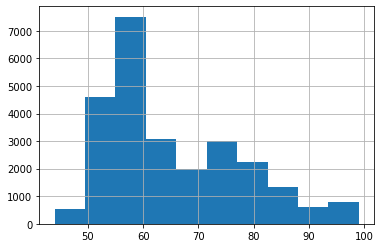

In [17]:
df2["hum"].hist()

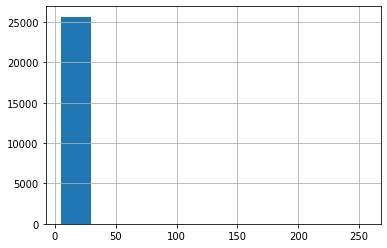

In [18]:
df2["temp"].hist()

The temperature histogram confirms there are outliers with high values. They cannot be seen by eye in the linear y-axis scale, they will only become apparent in a histogram with the logarithmic y-axis.

(array([2.5672e+04, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  5.,  30.,  55.,  80., 105., 130., 155., 180., 205., 230., 255.]),
 <a list of 10 Patch objects>)

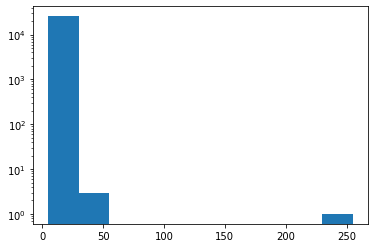

In [19]:
import matplotlib.pyplot as plt

plt.hist(df2['temp'], log=True) 

Box plots are useful show the basic statistics for the distributions, similar to what we achieved with `df.describe` previously.

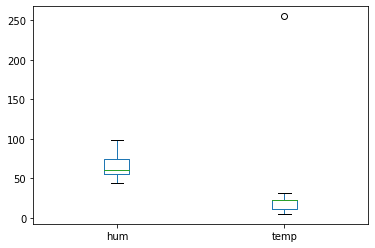

In [20]:
df2[["hum", "temp"]].plot.box()

We will remove the temperature outliers in the following way:

In [21]:
df2 = df2[df2["temp"] < 100]

The temperature can be plotted against time like this:

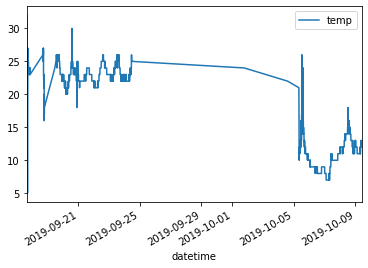

In [22]:
df2.plot(x="datetime", y="temp")

## Store results in the project volume

After data investigations/analysis in a notebook, we may want to save our results (data or plots) for later use/as a reference. This is what the project volume is for.

The example below shows how to save a plot of the humidity measurements after 05/10/2019 as a pdf file. The file can be downloaded from the file browser on the left.

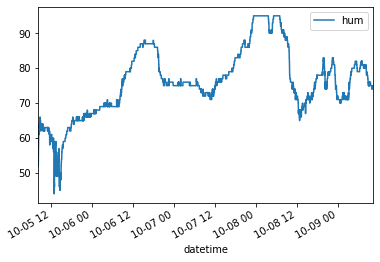

In [23]:
plot = df2[df2['datetime'] > '2019-10-05'].plot(x="datetime", y="hum")
plot.get_figure().savefig('humidity.pdf', format='pdf')